In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/salarypredictions/train_dataset.csv
/kaggle/input/salarypredictions/test_dataset.csv
/kaggle/input/salarypredictions/train_salaries.csv


In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 kB 11.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845513 sha256=8cc76fa62c11245fb8213da7d944e9d6487d8bc8ea6998b13952f45599843197
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [3]:
from pyspark.sql import *
from pyspark.sql import SparkSession
sc = SparkSession.builder.appName('employee_data').getOrCreate()
print(sc)
print(sc.version)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/03 06:10:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
3.3.1


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.style.use('ggplot')
sns.set_style("whitegrid")

from scipy import stats

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, VectorIndexer, StringIndexer, IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator 
from pyspark.ml.regression import GBTRegressor

In [5]:
path = '/kaggle/input/salarypredictions/'
df_path = path + 'train_dataset.csv'
df1_path = path + 'train_salaries.csv'

In [6]:
df1 = sc.read.csv(df_path, header=True).cache()

In [7]:
df2 = sc.read.csv(df1_path, header=True).cache()

In [8]:
df1.show()

+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|           jobId|companyId|       jobType|     degree|     major| industry|yearsExperience|milesFromMetropolis|
+----------------+---------+--------------+-----------+----------+---------+---------------+-------------------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|      MATH|   HEALTH|             10|                 83|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|      NONE|      WEB|              3|                 73|
|JOB1362684407689|   COMP52|VICE_PRESIDENT|   DOCTORAL|   PHYSICS|   HEALTH|             10|                 38|
|JOB1362684407690|   COMP38|       MANAGER|   DOCTORAL| CHEMISTRY|     AUTO|              8|                 17|
|JOB1362684407691|    COMP7|VICE_PRESIDENT|  BACHELORS|   PHYSICS|  FINANCE|              8|                 16|
|JOB1362684407692|   COMP15|       MANAGER|   DOCTORAL|   COMPSCI|  FINANCE|              2|    

In [9]:
df2.show()

+----------------+------+
|           jobId|salary|
+----------------+------+
|JOB1362684407687|   130|
|JOB1362684407688|   101|
|JOB1362684407689|   137|
|JOB1362684407690|   142|
|JOB1362684407691|   163|
|JOB1362684407692|   113|
|JOB1362684407693|   178|
|JOB1362684407694|    73|
|JOB1362684407695|    31|
|JOB1362684407696|   104|
|JOB1362684407697|   102|
|JOB1362684407698|   144|
|JOB1362684407699|    79|
|JOB1362684407700|   193|
|JOB1362684407701|    47|
|JOB1362684407702|   172|
|JOB1362684407703|    47|
|JOB1362684407704|   126|
|JOB1362684407705|   122|
|JOB1362684407706|    95|
+----------------+------+
only showing top 20 rows



In [10]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: string (nullable = true)
 |-- milesFromMetropolis: string (nullable = true)



In [11]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: string (nullable = true)



In [12]:
df1 = df1.withColumn("yearsExperience",df1.yearsExperience.cast('int'))
df1 = df1.withColumn("milesFromMetropolis",df1.milesFromMetropolis.cast('int'))

In [13]:
df2 = df2.withColumn("salary", df2.salary.cast('int'))

In [14]:
df1.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- companyId: string (nullable = true)
 |-- jobType: string (nullable = true)
 |-- degree: string (nullable = true)
 |-- major: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- yearsExperience: integer (nullable = true)
 |-- milesFromMetropolis: integer (nullable = true)



In [15]:
df2.printSchema()

root
 |-- jobId: string (nullable = true)
 |-- salary: integer (nullable = true)



In [16]:
df2 = df2.withColumnRenamed('jobId', 'job_id')
df = df1.join(df2, df1.jobId==df2.job_id)
df = df.drop('job_id')

In [17]:
df.show(5)

+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|           jobId|companyId|       jobType|     degree|    major| industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+--------------+-----------+---------+---------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|           CFO|    MASTERS|     MATH|   HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|           CEO|HIGH_SCHOOL|     NONE|      WEB|              3|                 73|   101|
|JOB1362684407693|   COMP15|           CFO|       NONE|     NONE|   HEALTH|             23|                 24|   178|
|JOB1362684407695|   COMP20|       JANITOR|HIGH_SCHOOL|     NONE|EDUCATION|              1|                 54|    31|
|JOB1362684407696|   COMP41|VICE_PRESIDENT|  BACHELORS|CHEMISTRY|     AUTO|             17|                 68|   104|
+----------------+---------+--------------+-----

In [18]:
df_dup=df.groupBy("yearsExperience", "milesFromMetropolis","companyId","jobType", "degree", "major", "industry", "jobId").count().filter("count > 1")
df_dup.drop('count').show()

+---------------+-------------------+---------+-------+------+-----+--------+-----+
|yearsExperience|milesFromMetropolis|companyId|jobType|degree|major|industry|jobId|
+---------------+-------------------+---------+-------+------+-----+--------+-----+
+---------------+-------------------+---------+-------+------+-----+--------+-----+



In [19]:
print('Number of missing values for jobType: {}'.format(df.filter(df.jobType=='NONE').count()))
print('Number of missing values for degree: {}'.format(df.filter(df.degree=='NONE').count()))
print('Number of missing values for major: {}'.format(df.filter(df.major=='NONE').count()))
print('Number of missing values for industry: {}'.format(df.filter(df.industry=='NONE').count()))


Number of missing values for jobType: 0


Number of missing values for degree: 236854


Number of missing values for major: 532355
Number of missing values for industry: 0


In [20]:
df.describe(['yearsExperience', 'milesFromMetropolis','salary']).show()

+-------+-----------------+-------------------+-----------------+
|summary|  yearsExperience|milesFromMetropolis|           salary|
+-------+-----------------+-------------------+-----------------+
|  count|          1000000|            1000000|          1000000|
|   mean|        11.992386|           49.52926|       116.061818|
| stddev|7.212390868885673| 28.877732628720036|38.71793638113296|
|    min|                0|                  0|                0|
|    max|               24|                 99|              301|
+-------+-----------------+-------------------+-----------------+



In [21]:
df.createOrReplaceTempView("data")

In [22]:
sc.sql('''
    SELECT salary, jobtype, industry
    FROM data
    WHERE salary == (SELECT MAX(salary) FROM data)''').show()

+------+-------+--------+
|salary|jobtype|industry|
+------+-------+--------+
|   301|    CFO|     OIL|
|   301|    CTO|     OIL|
+------+-------+--------+



In [23]:
df_q2 = sc.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary DESC) Rank
          FROM data
          ORDER BY salary DESC
          LIMIT 20''')
df_q2.show(20)

+------+-------+--------+----+
|salary|jobtype|industry|Rank|
+------+-------+--------+----+
|   301|    CFO|     OIL|   1|
|   301|    CTO|     OIL|   1|
|   298|    CEO|     OIL|   3|
|   294|    CEO|     OIL|   4|
|   294|    CEO| FINANCE|   1|
|   293|    CEO|     OIL|   5|
|   293|    CEO| FINANCE|   2|
|   292|    CEO| FINANCE|   3|
|   292|    CTO| FINANCE|   3|
|   290|    CEO|     WEB|   1|
|   289|    CTO|     WEB|   2|
|   289|    CFO|     OIL|   6|
|   289|    CEO| FINANCE|   5|
|   288|    CFO| FINANCE|   6|
|   288|    CFO| FINANCE|   6|
|   287|    CEO|     OIL|   7|
|   287|    CEO| FINANCE|   8|
|   286|    CEO|     OIL|   8|
|   286|    CTO| FINANCE|   9|
|   286|    CEO| FINANCE|   9|
+------+-------+--------+----+



In [24]:
sc.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''').show()

+------+--------------+---------+----+
|salary|       jobtype| industry|Rank|
+------+--------------+---------+----+
|     0|VICE_PRESIDENT|      WEB|   1|
|     0|       MANAGER|  FINANCE|   1|
|     0|           CTO|     AUTO|   1|
|     0|        JUNIOR|     AUTO|   1|
|     0|        JUNIOR|      OIL|   1|
|    17|       JANITOR|EDUCATION|   1|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    18|       JANITOR|EDUCATION|   2|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    19|       JANITOR|EDUCATION|   5|
|    20|       JANITOR|EDUCATION|  15|
+------+--------------+---------+----+
only showing top 20 rows



In [25]:
df = df.where("salary != 0")

In [26]:
df.createOrReplaceTempView("data")

In [27]:
df_q3 = sc.sql('''
          SELECT salary, jobtype, industry, RANK() OVER(PARTITION BY industry ORDER BY salary ASC) Rank
          FROM data
          ORDER BY salary ASC''')
df_q3.show()

+------+-------+---------+----+
|salary|jobtype| industry|Rank|
+------+-------+---------+----+
|    17|JANITOR|EDUCATION|   1|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    18|JANITOR|EDUCATION|   2|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    19|JANITOR|EDUCATION|   5|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
|    20|JANITOR|EDUCATION|  15|
+------+-------+---------+----+
only showing top 20 rows



In [28]:
df_q4 = sc.sql('''
          SELECT industry, AVG(salary) as average_salary
          FROM data
          GROUP BY industry
          ORDER BY average_salary DESC''')
df_q4.show(10)

+---------+------------------+
| industry|    average_salary|
+---------+------------------+
|      OIL|130.95386285634237|
|  FINANCE|  130.747658645164|
|      WEB| 121.6453615446388|
|   HEALTH| 115.7355399110364|
|     AUTO|109.43522152496485|
|  SERVICE|104.44682029458984|
|EDUCATION| 99.44838571898697|
+---------+------------------+



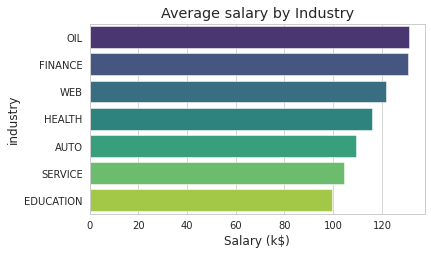

In [29]:
df_p = df_q4.toPandas()
plt.figure(figsize=(6,3.5))
sns.barplot(y='industry', x = 'average_salary', data=df_p, palette='viridis')
plt.title('Average salary by Industry')
plt.xlabel('Salary (k$)')
plt.show()

In [30]:
df_q5 = sc.sql('''
    SELECT salary, jobtype, industry, yearsExperience
    FROM data
    ORDER BY salary DESC
    ''') 
df_q5.show()

+------+-------+--------+---------------+
|salary|jobtype|industry|yearsExperience|
+------+-------+--------+---------------+
|   301|    CTO|     OIL|             24|
|   301|    CFO|     OIL|             23|
|   298|    CEO|     OIL|             22|
|   294|    CEO|     OIL|             19|
|   294|    CEO| FINANCE|             24|
|   293|    CEO| FINANCE|             16|
|   293|    CEO|     OIL|             24|
|   292|    CEO| FINANCE|             22|
|   292|    CTO| FINANCE|             24|
|   290|    CEO|     WEB|             20|
|   289|    CEO| FINANCE|             23|
|   289|    CFO|     OIL|             23|
|   289|    CTO|     WEB|             24|
|   288|    CFO| FINANCE|             24|
|   288|    CFO| FINANCE|             21|
|   287|    CEO| FINANCE|             19|
|   287|    CEO|     OIL|             22|
|   286|    CEO| FINANCE|             24|
|   286|    CTO| FINANCE|             24|
|   286|    CEO|     OIL|             16|
+------+-------+--------+---------

In [31]:
df_q5.groupBy('jobtype').count().show()

+--------------+------+
|       jobtype| count|
+--------------+------+
|           CTO|125045|
|        JUNIOR|124592|
|       JANITOR|124971|
|           CFO|124369|
|           CEO|124778|
|       MANAGER|125120|
|VICE_PRESIDENT|125234|
|        SENIOR|125886|
+--------------+------+



In [32]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR','JANITOR']

In [33]:
df_p = df_q5.toPandas()

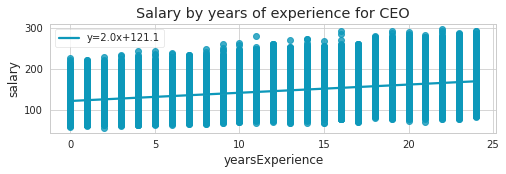

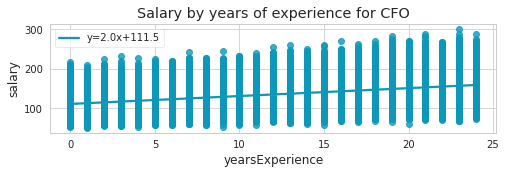

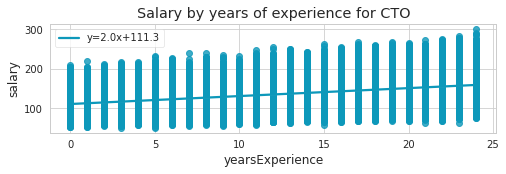

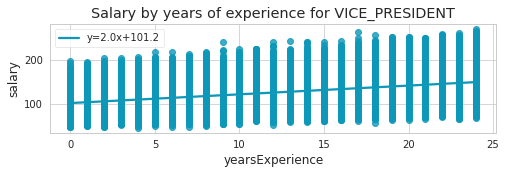

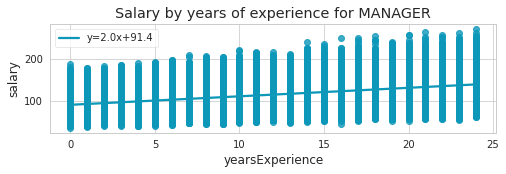

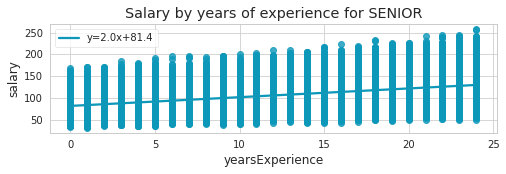

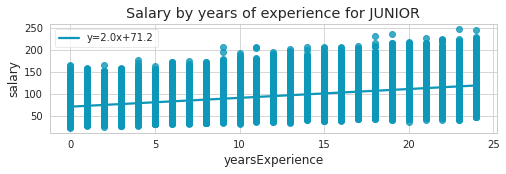

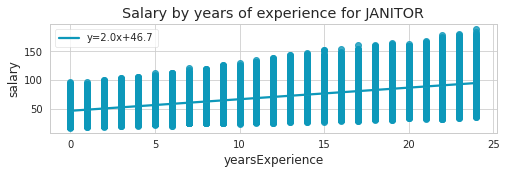

In [34]:
slope_list = []  #to save the slopes of the regression lines
intercept_list = [] #to save the intercepts of the regression lines

for job in job_list:
    df_x = df_p.loc[df_p['jobtype']==job]
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_x['yearsExperience'],df_x['salary'])
    slope_list.append(slope)
    intercept_list.append(intercept)
    plt.figure(figsize=(8,2))
    sns.regplot(x='yearsExperience', y = 'salary', data=df_x, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend()
    plt.title('Salary by years of experience for ' + job)
    plt.show()

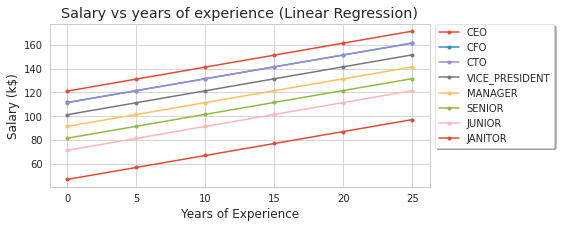

In [35]:
X = np.array([0, 5, 10, 15, 20, 25])
plt.figure(figsize=(6.8,3))
for i in range(8):
    plt.plot(X, slope_list[i]*X+intercept_list[i],label=job_list[i], marker='.')
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fancybox=True, shadow=True)
plt.ylabel('Salary (k$)')
plt.xlabel('Years of Experience')
plt.title('Salary vs years of experience (Linear Regression)')
plt.show()

In [36]:
df_q6 = sc.sql('''
                  SELECT degree, salary, jobtype
                  FROM data
                  ORDER BY salary
                  ''')
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       NONE|    17|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       NONE|    18|JANITOR|
|       NONE|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [37]:
df_q6 = df_q6.replace('NONE',None)

In [38]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|       null|    17|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|       null|    18|JANITOR|
|       null|    19|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [39]:
df_q6 = df_q6.na.drop()

In [40]:
df_q6.show(5)

+-----------+------+-------+
|     degree|salary|jobtype|
+-----------+------+-------+
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    18|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    19|JANITOR|
|HIGH_SCHOOL|    20|JANITOR|
+-----------+------+-------+
only showing top 5 rows



In [41]:
df_q6.groupBy('degree').count().show()

+-----------+------+
|     degree| count|
+-----------+------+
|  BACHELORS|175495|
|    MASTERS|175310|
|HIGH_SCHOOL|236975|
|   DOCTORAL|175362|
+-----------+------+



In [42]:
degrees_list = ['HIGH_SCHOOL','BACHELORS','DOCTORAL','MASTERS']

In [43]:
df_p = df_q6.toPandas()

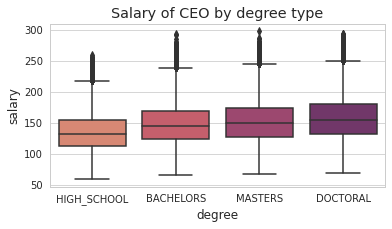

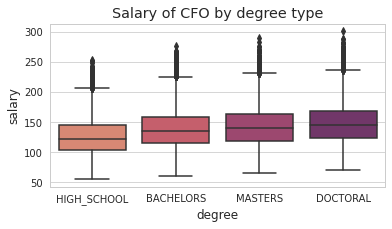

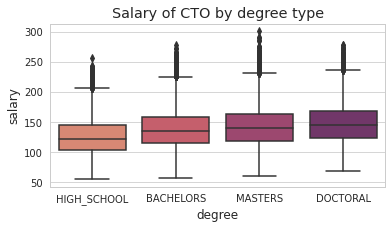

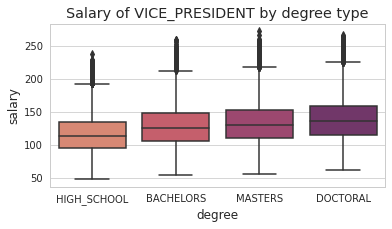

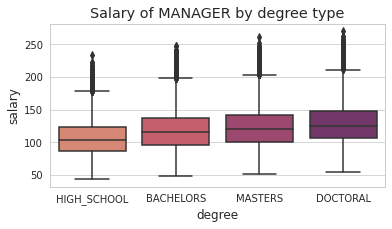

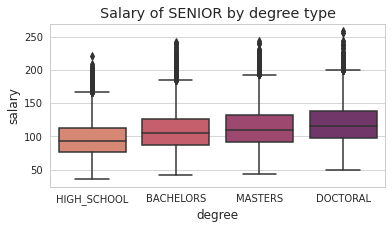

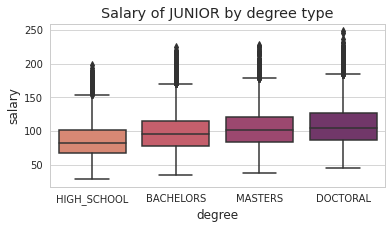

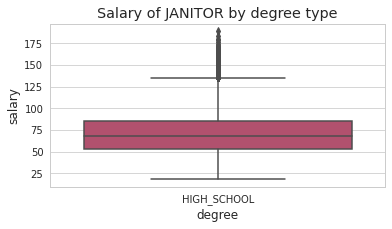

In [44]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(6,3))
  sns.boxplot(x='degree', y = 'salary', data=df_x, palette='flare')
  plt.title('Salary of ' + job + ' by degree type')
  plt.show()

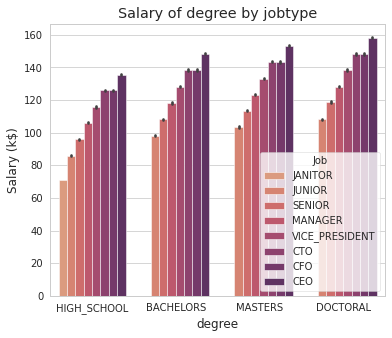

In [45]:
plt.figure(figsize=(6,5))
sns.barplot(x='degree', y = 'salary', data=df_p, hue='jobtype', palette='flare')
plt.legend(loc='lower right', title='Job')
plt.ylabel('Salary (k$)')
plt.title('Salary of degree by jobtype')
plt.show()

In [46]:
df_q7 = sc.sql('''
                  SELECT jobtype, degree, major, salary
                  FROM data
                  ORDER BY salary''')
df_q7.show(5)

+-------+-----------+-----+------+
|jobtype|     degree|major|salary|
+-------+-----------+-----+------+
|JANITOR|       NONE| NONE|    17|
|JANITOR|       NONE| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|HIGH_SCHOOL| NONE|    18|
|JANITOR|       NONE| NONE|    19|
+-------+-----------+-----+------+
only showing top 5 rows



In [47]:
df_q7 = df_q7.replace('NONE',None)
df_q7 = df_q7.na.drop()

In [48]:
df_q7.groupBy('major').count().show()

+-----------+-----+
|      major|count|
+-----------+-----+
|    BIOLOGY|58379|
|ENGINEERING|58594|
|    PHYSICS|58410|
|  CHEMISTRY|58875|
|   BUSINESS|58518|
|       MATH|57800|
|    COMPSCI|58382|
| LITERATURE|58684|
+-----------+-----+



In [49]:
df_q7.groupBy('jobtype').count().show()

+--------------+-----+
|       jobtype|count|
+--------------+-----+
|           CTO|66885|
|        JUNIOR|66465|
|           CFO|66427|
|           CEO|66754|
|       MANAGER|66832|
|VICE_PRESIDENT|66771|
|        SENIOR|67508|
+--------------+-----+



In [50]:
job_list = ['CEO','CFO','CTO','VICE_PRESIDENT','MANAGER','SENIOR','JUNIOR']

In [51]:
df_p = df_q7.toPandas()


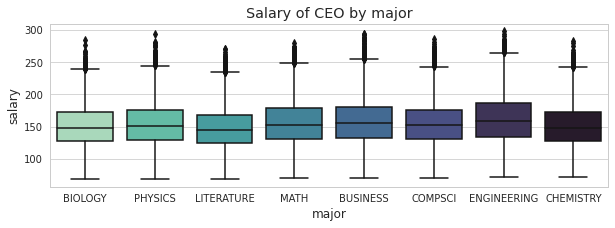

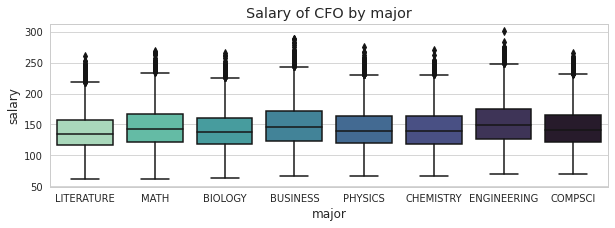

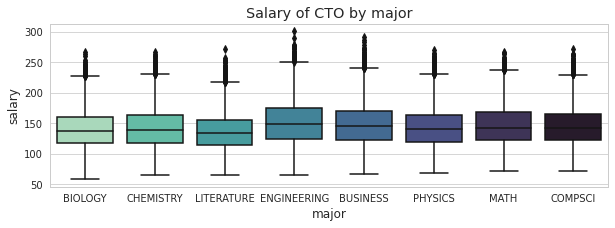

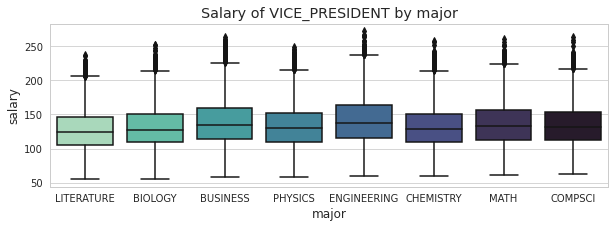

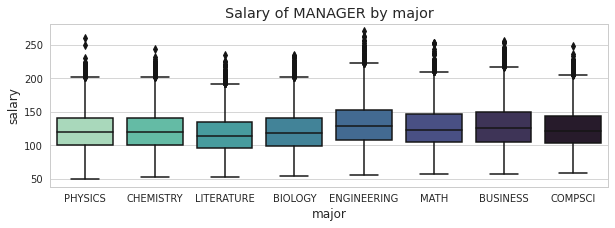

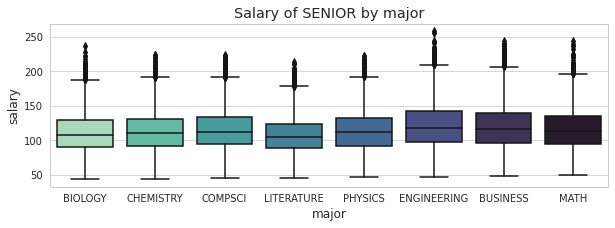

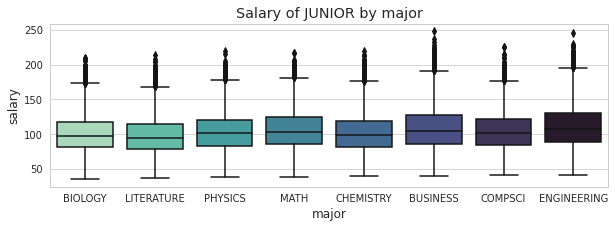

In [52]:
for job in job_list:
  df_x = df_p.loc[df_p['jobtype']==job]
  plt.figure(figsize=(10,3))
  sns.boxplot(x='major', y = 'salary', data=df_x, palette='mako_r')
  plt.title('Salary of ' + job + ' by major')
  plt.show()

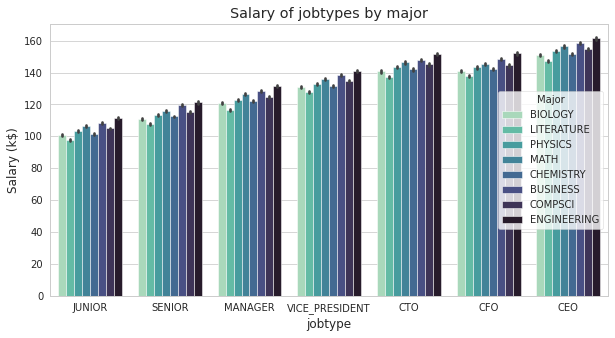

In [53]:
plt.figure(figsize=(10,5))
sns.barplot(x='jobtype', y = 'salary', data=df_p, hue='major', palette='mako_r')
plt.legend(loc='center right', title='Major')
plt.ylabel('Salary (k$)')
plt.title('Salary of jobtypes by major')
plt.show()

In [54]:
df.show(2)

+----------------+---------+-------+-----------+-----+--------+---------------+-------------------+------+
|           jobId|companyId|jobType|     degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+----------------+---------+-------+-----------+-----+--------+---------------+-------------------+------+
|JOB1362684407687|   COMP37|    CFO|    MASTERS| MATH|  HEALTH|             10|                 83|   130|
|JOB1362684407688|   COMP19|    CEO|HIGH_SCHOOL| NONE|     WEB|              3|                 73|   101|
+----------------+---------+-------+-----------+-----+--------+---------------+-------------------+------+
only showing top 2 rows



In [55]:
df_encoded = df.alias('df_encoded')
id(df_encoded) == id(df)  # False

False

In [56]:
df_encoded = df_encoded.drop('jobId')

In [57]:
cols = df_encoded.columns
print(cols)

['companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis', 'salary']


In [58]:
salary_df = df_encoded.select('salary').toPandas()

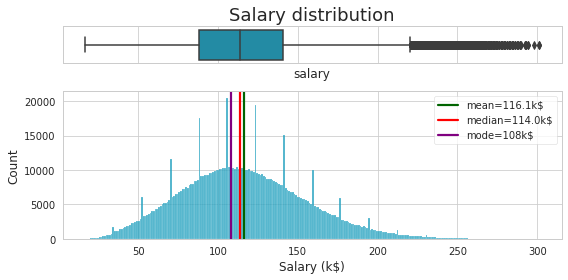

In [59]:
salary_df = df_encoded.select('salary').toPandas()
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,4),gridspec_kw={"height_ratios": (.2, .8)})
ax[0].set_title('Salary distribution',fontsize=18)
sns.boxplot(x='salary', data=salary_df, ax=ax[0], color='#0d98ba')
ax[0].set(yticks=[])
sns.histplot(x='salary', data=salary_df, ax=ax[1], color='#0d98ba')
plt.axvline(salary_df['salary'].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(salary_df['salary'].mean(),1)) + 'k$')
plt.axvline(salary_df['salary'].median(), color='red', linewidth=2.2, label='median='+ str(np.round(salary_df['salary'].median(),1)) + 'k$')
plt.axvline(salary_df['salary'].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(salary_df['salary'].mode()[0]) + 'k$')
ax[1].set_xlabel('Salary (k$)')
plt.legend()
plt.tight_layout()
plt.show()

In [60]:
categoricalColumns = ["companyId","jobType", "degree", "major", "industry"]
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    stages += [stringIndexer]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [61]:
stages = []
stringIndexer = StringIndexer(inputCol = "degree", outputCol = "degreeIndex")
stages += [stringIndexer]

In [62]:
categoricalColumns = ["companyId","jobType", "major", "industry"]
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols =  ["yearsExperience", "milesFromMetropolis"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols + ["degreeIndex"]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [63]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_encoded)
df_encoded = pipelineModel.transform(df_encoded)
selectedCols = ['features'] + cols
df_encoded = df_encoded.select(selectedCols)

In [64]:
df_encoded.show(1)

+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|            features|companyId|jobType| degree|major|industry|yearsExperience|milesFromMetropolis|salary|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
|(86,[29,82,83,84,...|   COMP37|    CFO|MASTERS| MATH|  HEALTH|             10|                 83|   130|
+--------------------+---------+-------+-------+-----+--------+---------------+-------------------+------+
only showing top 1 row



In [65]:
train, test = df_encoded.randomSplit([0.8, 0.2], seed = 42)
print("There are %d training examples and %d test examples." % (train.count(), test.count()))

There are 799647 training examples and 200348 test examples.


In [66]:
gbt =  GBTRegressor(featuresCol="features", labelCol="salary", maxBins=20, maxDepth=12)

In [67]:
gbt_model = gbt.fit(train)

23/01/03 06:16:21 WARN MemoryStore: Not enough space to cache rdd_811_3 in memory! (computed 31.2 MiB so far)
23/01/03 06:16:21 WARN BlockManager: Persisting block rdd_811_3 to disk instead.
23/01/03 06:16:21 WARN MemoryStore: Not enough space to cache rdd_811_0 in memory! (computed 13.7 MiB so far)
23/01/03 06:16:21 WARN BlockManager: Persisting block rdd_811_0 to disk instead.
23/01/03 06:16:21 WARN MemoryStore: Not enough space to cache rdd_811_2 in memory! (computed 31.2 MiB so far)
23/01/03 06:16:21 WARN BlockManager: Persisting block rdd_811_2 to disk instead.
23/01/03 06:16:21 WARN MemoryStore: Not enough space to cache rdd_811_1 in memory! (computed 46.9 MiB so far)
23/01/03 06:16:21 WARN BlockManager: Persisting block rdd_811_1 to disk instead.


23/01/03 06:16:42 WARN DAGScheduler: Broadcasting large task binary with size 1097.5 KiB


23/01/03 06:16:43 WARN DAGScheduler: Broadcasting large task binary with size 1319.0 KiB
23/01/03 06:16:44 WARN DAGScheduler: Broadcasting large task binary with size 1324.0 KiB


23/01/03 06:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1324.6 KiB
23/01/03 06:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1325.4 KiB
23/01/03 06:16:47 WARN DAGScheduler: Broadcasting large task binary with size 1326.5 KiB
23/01/03 06:16:47 WARN DAGScheduler: Broadcasting large task binary with size 1329.0 KiB
23/01/03 06:16:48 WARN DAGScheduler: Broadcasting large task binary with size 1334.0 KiB
23/01/03 06:16:48 WARN DAGScheduler: Broadcasting large task binary with size 1343.9 KiB
23/01/03 06:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1363.6 KiB


23/01/03 06:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1400.8 KiB
23/01/03 06:16:50 WARN DAGScheduler: Broadcasting large task binary with size 1471.4 KiB


23/01/03 06:16:51 WARN DAGScheduler: Broadcasting large task binary with size 1598.2 KiB


23/01/03 06:16:52 WARN DAGScheduler: Broadcasting large task binary with size 1811.4 KiB


23/01/03 06:16:54 WARN DAGScheduler: Broadcasting large task binary with size 1814.9 KiB


23/01/03 06:16:55 WARN DAGScheduler: Broadcasting large task binary with size 1815.5 KiB
23/01/03 06:16:56 WARN DAGScheduler: Broadcasting large task binary with size 1816.3 KiB


23/01/03 06:16:56 WARN DAGScheduler: Broadcasting large task binary with size 1817.4 KiB
23/01/03 06:16:57 WARN DAGScheduler: Broadcasting large task binary with size 1819.9 KiB
23/01/03 06:16:57 WARN DAGScheduler: Broadcasting large task binary with size 1824.8 KiB
23/01/03 06:16:58 WARN DAGScheduler: Broadcasting large task binary with size 1834.6 KiB
23/01/03 06:16:59 WARN DAGScheduler: Broadcasting large task binary with size 1854.4 KiB
23/01/03 06:16:59 WARN DAGScheduler: Broadcasting large task binary with size 1892.2 KiB


23/01/03 06:17:00 WARN DAGScheduler: Broadcasting large task binary with size 1964.0 KiB


23/01/03 06:17:01 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


23/01/03 06:17:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/01/03 06:17:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/01/03 06:17:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/01/03 06:17:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


23/01/03 06:17:06 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/01/03 06:17:07 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/01/03 06:17:08 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/01/03 06:17:08 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/01/03 06:17:09 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/01/03 06:17:10 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


23/01/03 06:17:10 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


23/01/03 06:17:11 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


23/01/03 06:17:12 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


23/01/03 06:17:14 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


23/01/03 06:17:15 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/01/03 06:17:16 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


23/01/03 06:17:16 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/01/03 06:17:17 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
23/01/03 06:17:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


23/01/03 06:17:18 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
23/01/03 06:17:19 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/01/03 06:17:20 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


23/01/03 06:17:21 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


23/01/03 06:17:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


23/01/03 06:17:23 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


23/01/03 06:17:24 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


23/01/03 06:17:25 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


23/01/03 06:17:26 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
23/01/03 06:17:27 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


23/01/03 06:17:28 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


23/01/03 06:17:28 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


23/01/03 06:17:29 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


23/01/03 06:17:30 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


23/01/03 06:17:30 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


23/01/03 06:17:31 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


23/01/03 06:17:32 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


23/01/03 06:17:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/01/03 06:17:35 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/01/03 06:17:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/01/03 06:17:38 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/01/03 06:17:38 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/01/03 06:17:39 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/01/03 06:17:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/01/03 06:17:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/01/03 06:17:41 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/01/03 06:17:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


23/01/03 06:17:43 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


23/01/03 06:17:44 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


23/01/03 06:17:45 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/01/03 06:17:46 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/01/03 06:17:48 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/01/03 06:17:49 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/01/03 06:17:50 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/01/03 06:17:50 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/01/03 06:17:51 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/01/03 06:17:52 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/01/03 06:17:53 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/01/03 06:17:54 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


23/01/03 06:17:55 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


23/01/03 06:17:56 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


23/01/03 06:17:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


23/01/03 06:17:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


23/01/03 06:18:00 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


23/01/03 06:18:01 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


23/01/03 06:18:02 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


23/01/03 06:18:02 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


23/01/03 06:18:03 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


23/01/03 06:18:04 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


23/01/03 06:18:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


23/01/03 06:18:06 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


23/01/03 06:18:07 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


23/01/03 06:18:08 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


23/01/03 06:18:09 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/01/03 06:18:11 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/01/03 06:18:12 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/01/03 06:18:13 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/01/03 06:18:14 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/01/03 06:18:15 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/01/03 06:18:16 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/01/03 06:18:17 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/01/03 06:18:18 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


23/01/03 06:18:19 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


23/01/03 06:18:20 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


23/01/03 06:18:21 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


23/01/03 06:18:22 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/01/03 06:18:23 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/01/03 06:18:25 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/01/03 06:18:26 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/01/03 06:18:27 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/01/03 06:18:28 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/01/03 06:18:28 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/01/03 06:18:29 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/01/03 06:18:30 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


23/01/03 06:18:31 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


23/01/03 06:18:32 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


23/01/03 06:18:34 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


23/01/03 06:18:35 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


23/01/03 06:18:37 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


23/01/03 06:18:38 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


23/01/03 06:18:39 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


23/01/03 06:18:41 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


23/01/03 06:18:42 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


23/01/03 06:18:43 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


23/01/03 06:18:44 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/01/03 06:18:45 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/01/03 06:18:46 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


23/01/03 06:18:47 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


23/01/03 06:18:48 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


23/01/03 06:18:49 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/01/03 06:18:51 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/01/03 06:18:52 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/01/03 06:18:53 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/01/03 06:18:54 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/01/03 06:18:55 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/01/03 06:18:56 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/01/03 06:18:57 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/01/03 06:18:58 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/01/03 06:18:59 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


23/01/03 06:19:00 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


23/01/03 06:19:02 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


23/01/03 06:19:03 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/01/03 06:19:04 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/01/03 06:19:06 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/01/03 06:19:07 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/01/03 06:19:08 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/01/03 06:19:09 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/01/03 06:19:10 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/01/03 06:19:11 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/01/03 06:19:13 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/01/03 06:19:14 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


23/01/03 06:19:15 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


23/01/03 06:19:16 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


23/01/03 06:19:17 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


23/01/03 06:19:19 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


23/01/03 06:19:20 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


23/01/03 06:19:21 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


23/01/03 06:19:22 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


23/01/03 06:19:24 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


23/01/03 06:19:25 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


23/01/03 06:19:26 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


23/01/03 06:19:27 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


23/01/03 06:19:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


23/01/03 06:19:29 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


23/01/03 06:19:30 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


23/01/03 06:19:32 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/01/03 06:19:34 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/01/03 06:19:35 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/01/03 06:19:36 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/01/03 06:19:37 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/01/03 06:19:39 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/01/03 06:19:40 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/01/03 06:19:41 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/01/03 06:19:42 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


23/01/03 06:19:43 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


23/01/03 06:19:45 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


23/01/03 06:19:46 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


23/01/03 06:19:47 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/01/03 06:19:49 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/01/03 06:19:51 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/01/03 06:19:52 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/01/03 06:19:53 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/01/03 06:19:54 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/01/03 06:19:56 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/01/03 06:19:57 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/01/03 06:19:58 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/01/03 06:19:59 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


23/01/03 06:20:00 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


23/01/03 06:20:02 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


23/01/03 06:20:03 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


23/01/03 06:20:05 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


23/01/03 06:20:07 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


23/01/03 06:20:09 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


23/01/03 06:20:10 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


23/01/03 06:20:11 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


23/01/03 06:20:12 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


23/01/03 06:20:13 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


23/01/03 06:20:15 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


23/01/03 06:20:16 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


23/01/03 06:20:18 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


23/01/03 06:20:19 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


23/01/03 06:20:20 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


23/01/03 06:20:22 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


23/01/03 06:20:24 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


23/01/03 06:20:25 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


23/01/03 06:20:26 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


23/01/03 06:20:28 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


23/01/03 06:20:29 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


23/01/03 06:20:30 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


23/01/03 06:20:31 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


23/01/03 06:20:33 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


23/01/03 06:20:34 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


23/01/03 06:20:35 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


23/01/03 06:20:37 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


In [68]:
predictions = gbt_model.transform(test)

In [69]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rmse

19.354502766444117

In [70]:
evaluator = RegressionEvaluator(labelCol="salary", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
r2

0.7500469486196656

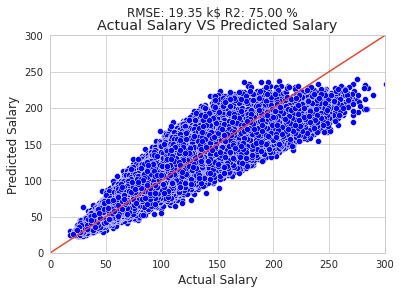

In [71]:
rf_results = predictions.toPandas()
sns.scatterplot(x='salary', y='prediction', data=rf_results, color='blue')
plt.plot([0, 300], [0, 300])
plt.axis([0, 300, 0, 300])
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.suptitle("RMSE: {:.2f} k$ R2: {:.2f} %".format(rmse, r2*100))
plt.title('Actual Salary VS Predicted Salary')
plt.show()

In [72]:
print("RMSE: {:.2f} \nR2: {:.2f} %".format(rmse, r2*100))

RMSE: 19.35 
R2: 75.00 %


In [73]:
sc.stop()